In [ ]:
!pip install prophet
!pip install neuralprophet[live]

In [2]:
import random
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import prophet
import numpy as np
import seaborn as sns
import xgboost as xgb

from fbprophet import Prophet
from google.colab import drive
from neuralprophet import NeuralProphet
from prophet.diagnostics import cross_validation, performance_metrics
from random import shuffle
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

Some parameters are needed.


*   `DATA_PATH` : path to the data (format .csv)
*   `N_PERIOD_OUTPUT` : number of periods to be predicted
*   `N_PERIOD_INPUT` : maximum lag for the target variable as feature
*   `CUT_TRAINING` : obervation number to split the train and test sets.

In our case, we choose to set `N_PERIOD_OUTPUT` and `N_PERIOD_INPUT` to 24 because we work with hourly time series.



In [3]:
DATA_PATH = r'data/traffic.csv'
N_PERIOD_OUTPUT = 24
N_PERIOD_INPUT = 24
CUT_TRAINING = 10392

The dataset `traffic.npy` contains 963 time series. We will only work with the first time series.

In [4]:
df = pd.read_csv(DATA_PATH)
df.head(5)

,y
0,0.020933
1,0.019333
2,0.020200
3,0.022450
4,0.029283


# Model training

## XGBoost


After embedding the time variable (here we assume that the data starts on January 1, 2012), we create the time-covariates that we rescale between -0.5 and 0.5.

In [5]:
df = (df.
 assign(ds = pd.date_range(start=datetime(2012, 1, 1, 00, 00, 00), freq='1H', periods=len(df)),
        month = lambda x: x['ds'].dt.month,
        day = lambda x: x['ds'].dt.day,
        hour = lambda x: x['ds'].dt.hour,
        weekday = lambda x: x['ds'].dt.weekday,
        dayofyear = lambda x: x['ds'].dt.dayofyear,
        weekofyear = lambda x: x['ds'].dt.isocalendar().reset_index().week))

features = ['month', 'day', 'hour', 'weekday', 'dayofyear', 'weekofyear']
df[features] = MinMaxScaler(feature_range=(-0.5, 0.5)).fit_transform(df[features])

df.head(5)

,y,ds,month,day,hour,weekday,dayofyear,weekofyear
0,0.020933,2012-01-01 00:00:00,-0.5,-0.5,-0.500000,0.5,-0.5,0.5
1,0.019333,2012-01-01 01:00:00,-0.5,-0.5,-0.456522,0.5,-0.5,0.5
2,0.020200,2012-01-01 02:00:00,-0.5,-0.5,-0.413043,0.5,-0.5,0.5
3,0.022450,2012-01-01 03:00:00,-0.5,-0.5,-0.369565,0.5,-0.5,0.5
4,0.029283,2012-01-01 04:00:00,-0.5,-0.5,-0.326087,0.5,-0.5,0.5


The features are composed of two sets.

*   The last `N_PERIOD_OUTPUT` (here 24) target values.
*   The time-covariate only for the period t.

In our case, we have 6 time-covariate and 24 past target values. Therefore, we have 30 features.

Because we implement a multioutput algorithm, the target variable is a 24-N dimensional set.

In [6]:
X, Y = [], []

for i in range(N_PERIOD_INPUT, len(df)-N_PERIOD_OUTPUT+1):
  X_past_target = np.array(df.loc[i-N_PERIOD_INPUT:i-1, 'y'])
  X_time_covariates = np.array(df.loc[i-1, features])
  Y_future_target = np.array(df.loc[i:i+N_PERIOD_OUTPUT-1, 'y'])
  X_features = np.hstack((X_past_target, X_time_covariates))

  Y.append(Y_future_target)
  X.append(X_features)

We convert the Y and X sets from list to array.

In [7]:
Y = np.reshape(Y, (len(Y), len(Y[0])))
X = np.reshape(X, (len(X), len(X[0])))

print(f'Y shape : {Y.shape} - X shape : {X.shape}')

Y shape : (10513, 24) - X shape : (10513, 30)


Now, we can split our sets between train and test. Because we have removed 24 values in the previous loop, the split is a bit shifted.

In [8]:
Y_train = Y[0:CUT_TRAINING-N_PERIOD_INPUT,:].astype('float32')
X_train = X[0:CUT_TRAINING-N_PERIOD_INPUT,:].astype('float32')

Y_test = Y[CUT_TRAINING-N_PERIOD_INPUT:,:].astype('float32')
X_test = X[CUT_TRAINING-N_PERIOD_INPUT:,:].astype('float32')

For reason I do not understand for now, the authors decide to randomly shuffle the train set. We replicate it here.

In [9]:
order = list(range(0, len(Y_train)))
random.shuffle(order)

Y_train = Y_train[order]
X_train = X_train[order]

In order to obtain as many values as there are periods in the test sample, we decide to make the predictions each day at time zero, thus recovering 24 periods per day.

In [10]:
numb_of_days = int((Y_test.shape[0]-1)/24)+1
to_select = np.multiply(range(0, numb_of_days), 24)

Y_test = Y_test[to_select]
X_test = X_test[to_select]

Limited by the computational power, I decide to keep the parameters proposed by the authors, which have been optimized on the same dataset as mine but considering 90 time series.

In [ ]:
model = xgb.XGBRegressor(learning_rate=0.2,
                          n_estimators=800,
                          max_depth=8,
                          min_child_weight=1,
                          gamma=0.0,
                          subsample=0.8, 
                          colsample_bytree=0.8,
                          scale_pos_weight=1,
                          seed=42,
                          silent=False)

xgb_multioutput = MultiOutputRegressor(model).fit(X_train, Y_train)
#24 warning messages should be printed

Saving the model

In [13]:
pickle.dump(xgb_multioutput, open("model/xgb_multioutput.pkl", 'wb'))

## Prophet

We create a boolean, named `train`, indicating the train set.

In [14]:
train = np.repeat(False, len(df))
train[:CUT_TRAINING] = True

We fit a standard Prophet model to our train set.

In [ ]:
m_Prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

m_Prophet.fit(df.loc[train, ['ds', 'y']])

## Neural Prophet

We fit a standard Neural Prophet model to our train set.

In [ ]:
m_NeuralProphet = NeuralProphet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

m_NeuralProphet.fit(df.loc[train, ['ds', 'y']])

# Prediction

We compute the predictions on the test sample. The `np.hstack` function allows to convert the multiouput format into an array format. 

In [ ]:
df.loc[~train, "pred_xgb"] = np.hstack(xgb_multioutput.predict(X_test))
df.loc[~train, ['pred_prophet']] = np.array(m_Prophet.predict(df.loc[~train, ['ds']])['yhat'])
df.loc[~train, ['pred_neural_prophet']] = np.array(m_NeuralProphet.predict(df.loc[~train, ['ds', 'y']])['yhat1'])

# Visualisation

By visualizing the results obtained from the test sample, we observe that the XGBoost-based model fits the data much better than Prophet and Neural Prophet.

Text(0.5, 1.0, 'Prediction : Neural Prophet')

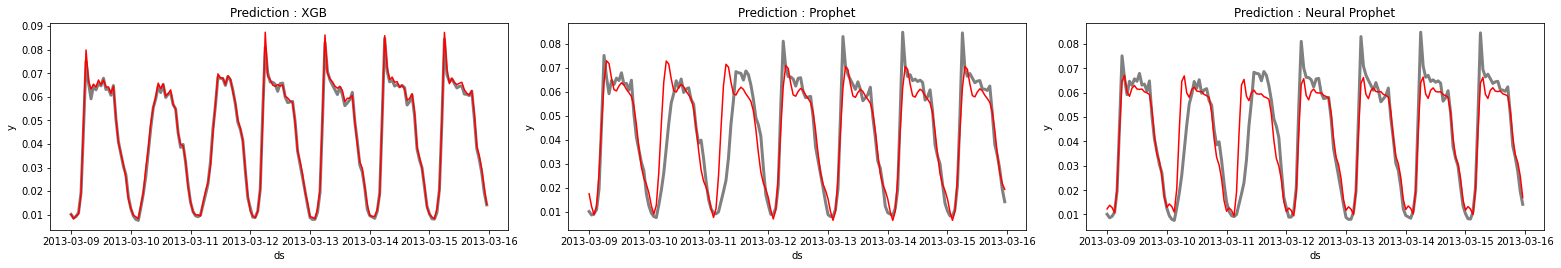

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(22,4))
fig.tight_layout(pad = 3.0)

a = sns.lineplot(ax = axes[0], x='ds', y='y', data=df[~train], lw=3, color = "grey")
a = sns.lineplot(ax = axes[0], x='ds', y='pred_xgb', data=df[~train], color = "red")
a.set_title('Prediction : XGB')

a = sns.lineplot(ax = axes[1], x='ds', y='y', data=df[~train], lw=3, color = "grey")
a = sns.lineplot(ax = axes[1], x='ds', y='pred_prophet', data=df[~train], color = "red")
a.set_title('Prediction : Prophet')

a = sns.lineplot(ax = axes[2], x='ds', y='y', data=df[~train], lw=3, color = "grey")
a = sns.lineplot(ax = axes[2], x='ds', y='pred_neural_prophet', data=df[~train], color = "red")
a.set_title('Prediction : Neural Prophet')

# Evaluation

We define a function allowing us to compute some evaluation statistics.

In [19]:
def evaluation(true, pred):
  MSE = np.mean((true - pred)**2)
  MAE = np.mean(np.abs((true - pred)))
  MAPE = np.mean((np.abs(true - pred)/np.abs(pred)))
  WAPE = np.sum(np.abs(true - pred))/np.sum(np.abs(pred))

  return np.array([MSE, MAE, MAPE, WAPE])

The XGBoost model is clearly better than the other two.

In [20]:
pd.DataFrame({'XGB': evaluation(df['y'], df['pred_xgb']),
              'Neural_Prophet': evaluation(df['y'], df['pred_neural_prophet']),
              'Prophet': evaluation(df['y'], df['pred_prophet'])},
             index = ['MSE', 'MAE', 'MAPE', 'WAPE'])

,XGB,Neural_Prophet,Prophet
MSE,0.000002,0.000080,0.000100
MAE,0.000980,0.005432,0.005867
MAPE,0.029284,0.143973,0.150244
WAPE,0.022280,0.125669,0.133298
